I used python 3.11 environment; but that shouldn't matter too much.

In [1]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from root import *
from old_func import *
from PIL import Image, ImageDraw
from typing import List, Tuple, Set
import time
from tree_coverage import TimeAwareTreeCoverage

Most analysis was done with the root object class. `left_root` and `right_root` each is a root object, with primary and lateral attributes, and each contains a set of nodes.

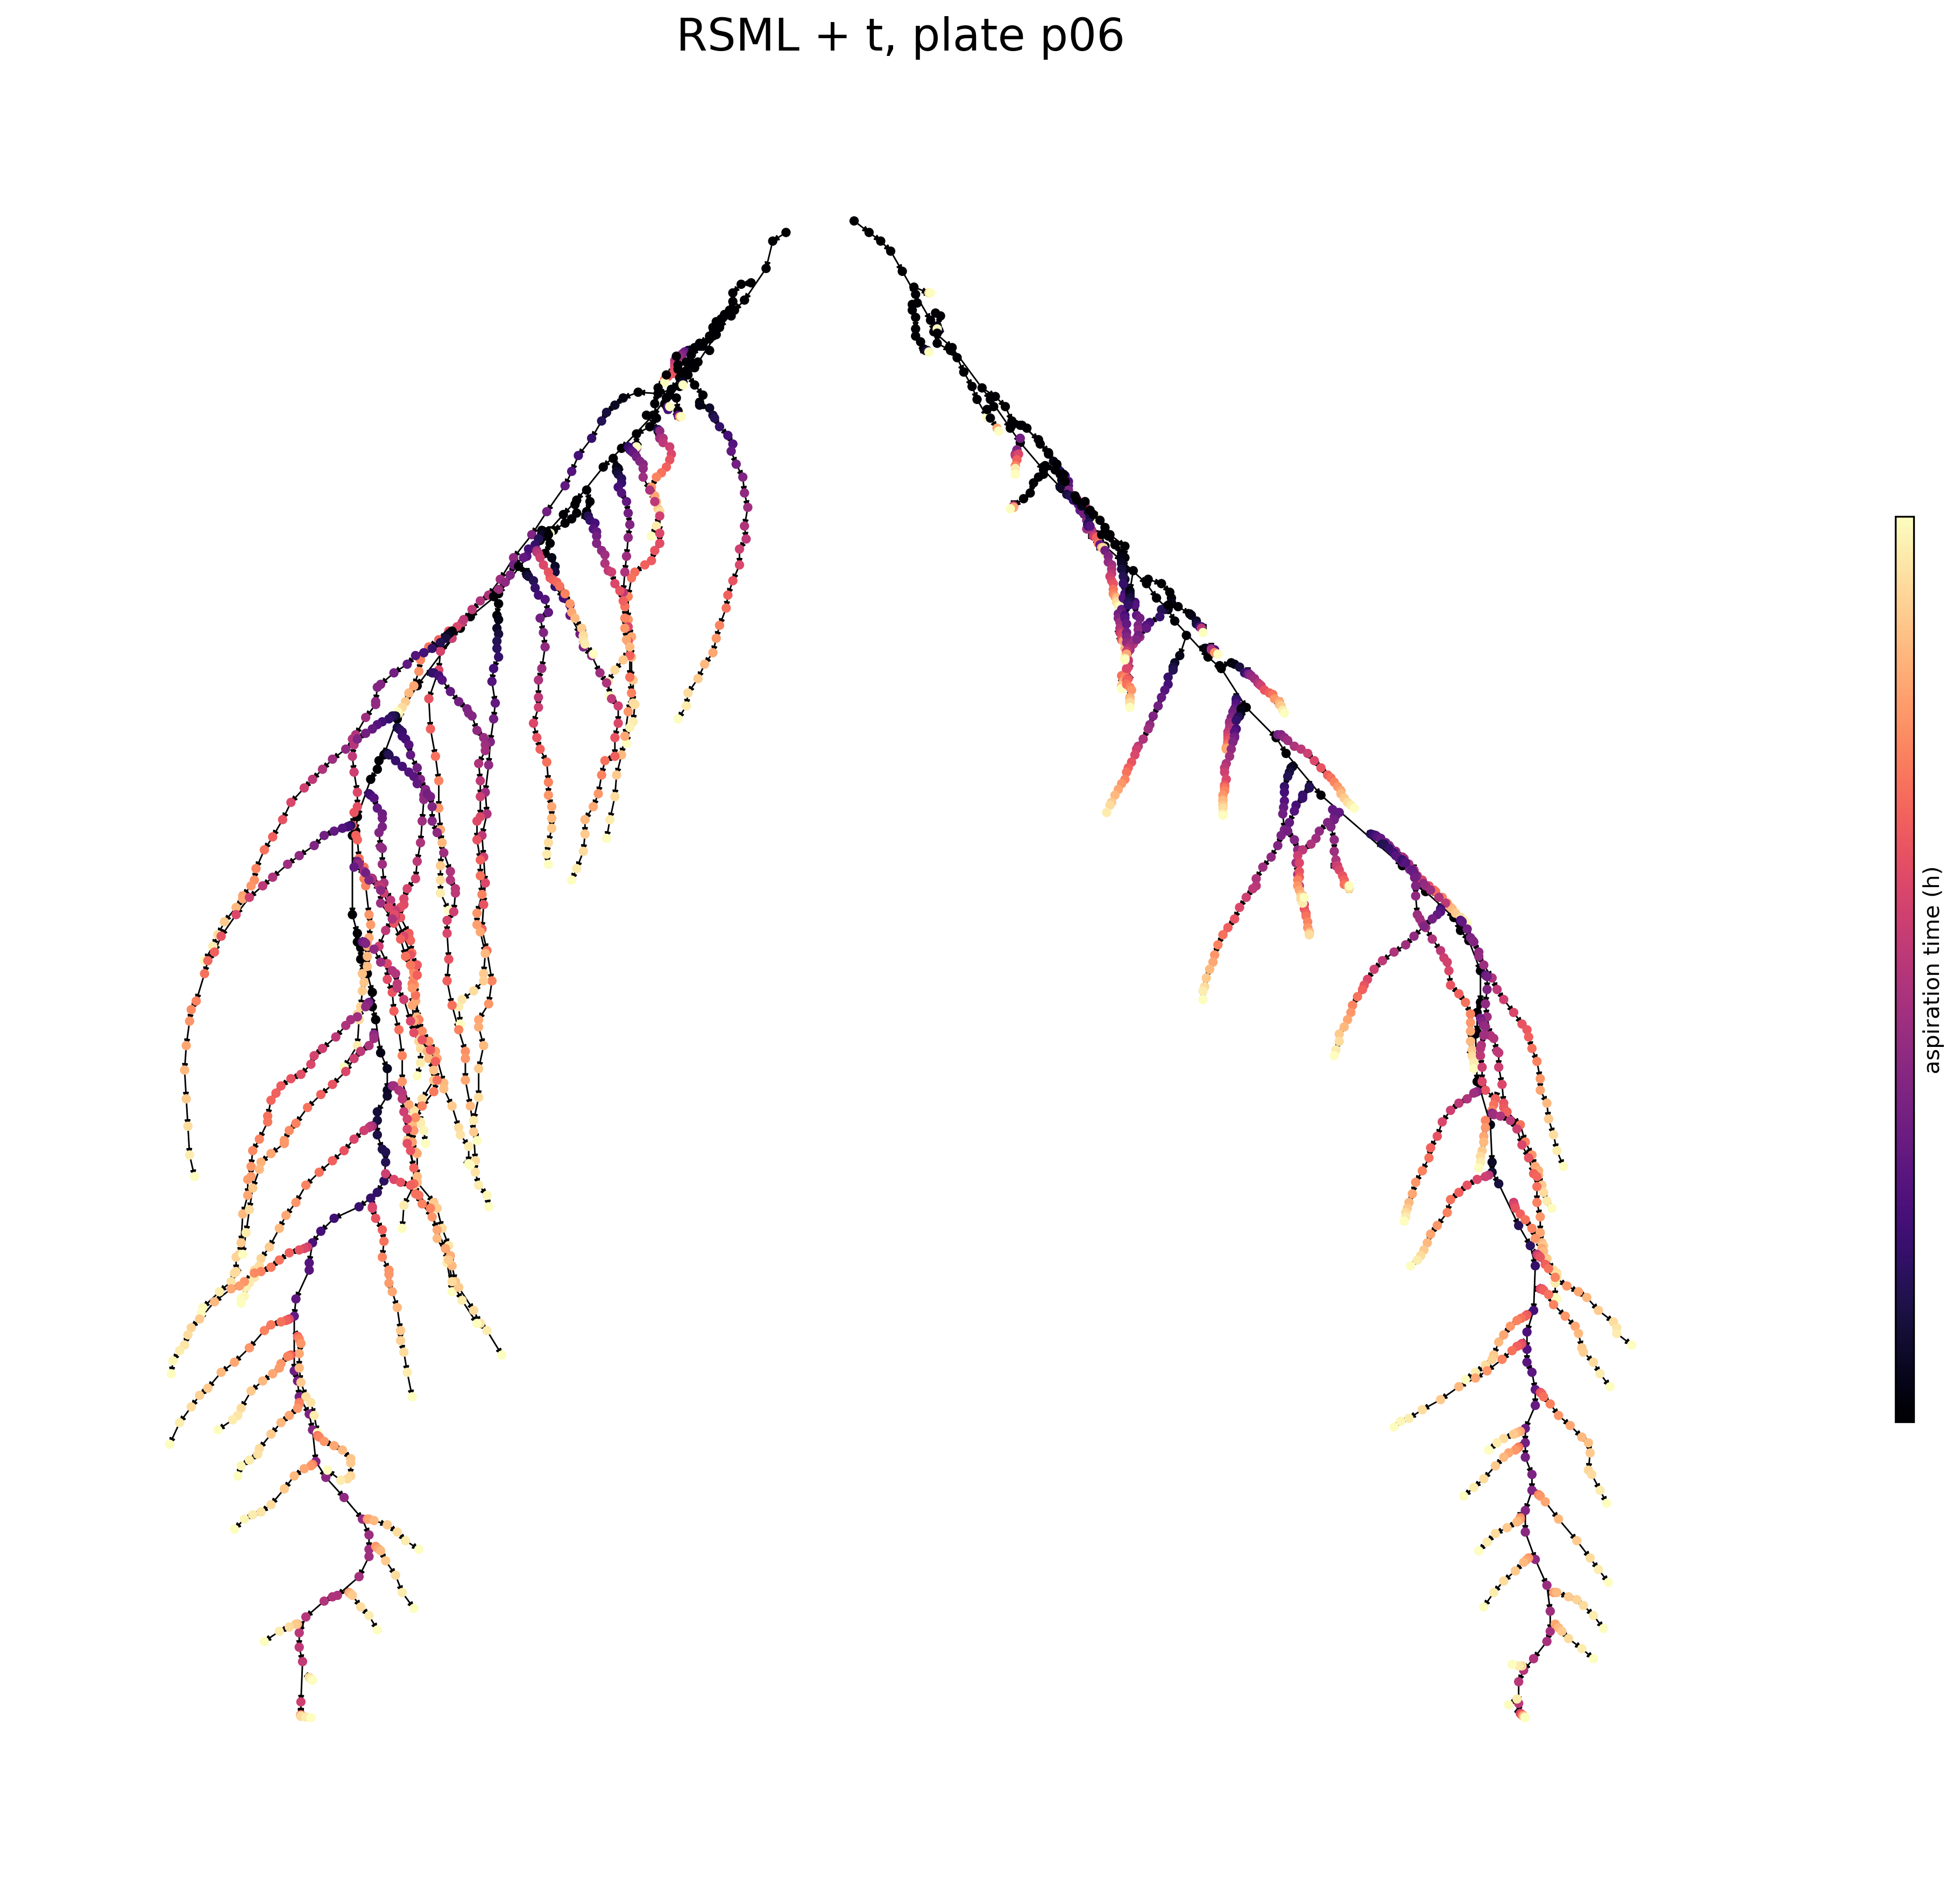

In [2]:
file = 'p06.rsml' # 06 has low high heterogenous nutrient, 04 has high high homogeneous nutrient, 15 has low low homogeneous nutrient.
left_root, right_root, r = splitrsml2root(file)
G_root, r = rsml2nx(file)
plot_rsmlt(G_root, plate= 'p06',  save_name= None)

Can also read as a networkx object, with some visualization, colored by node emergence time.

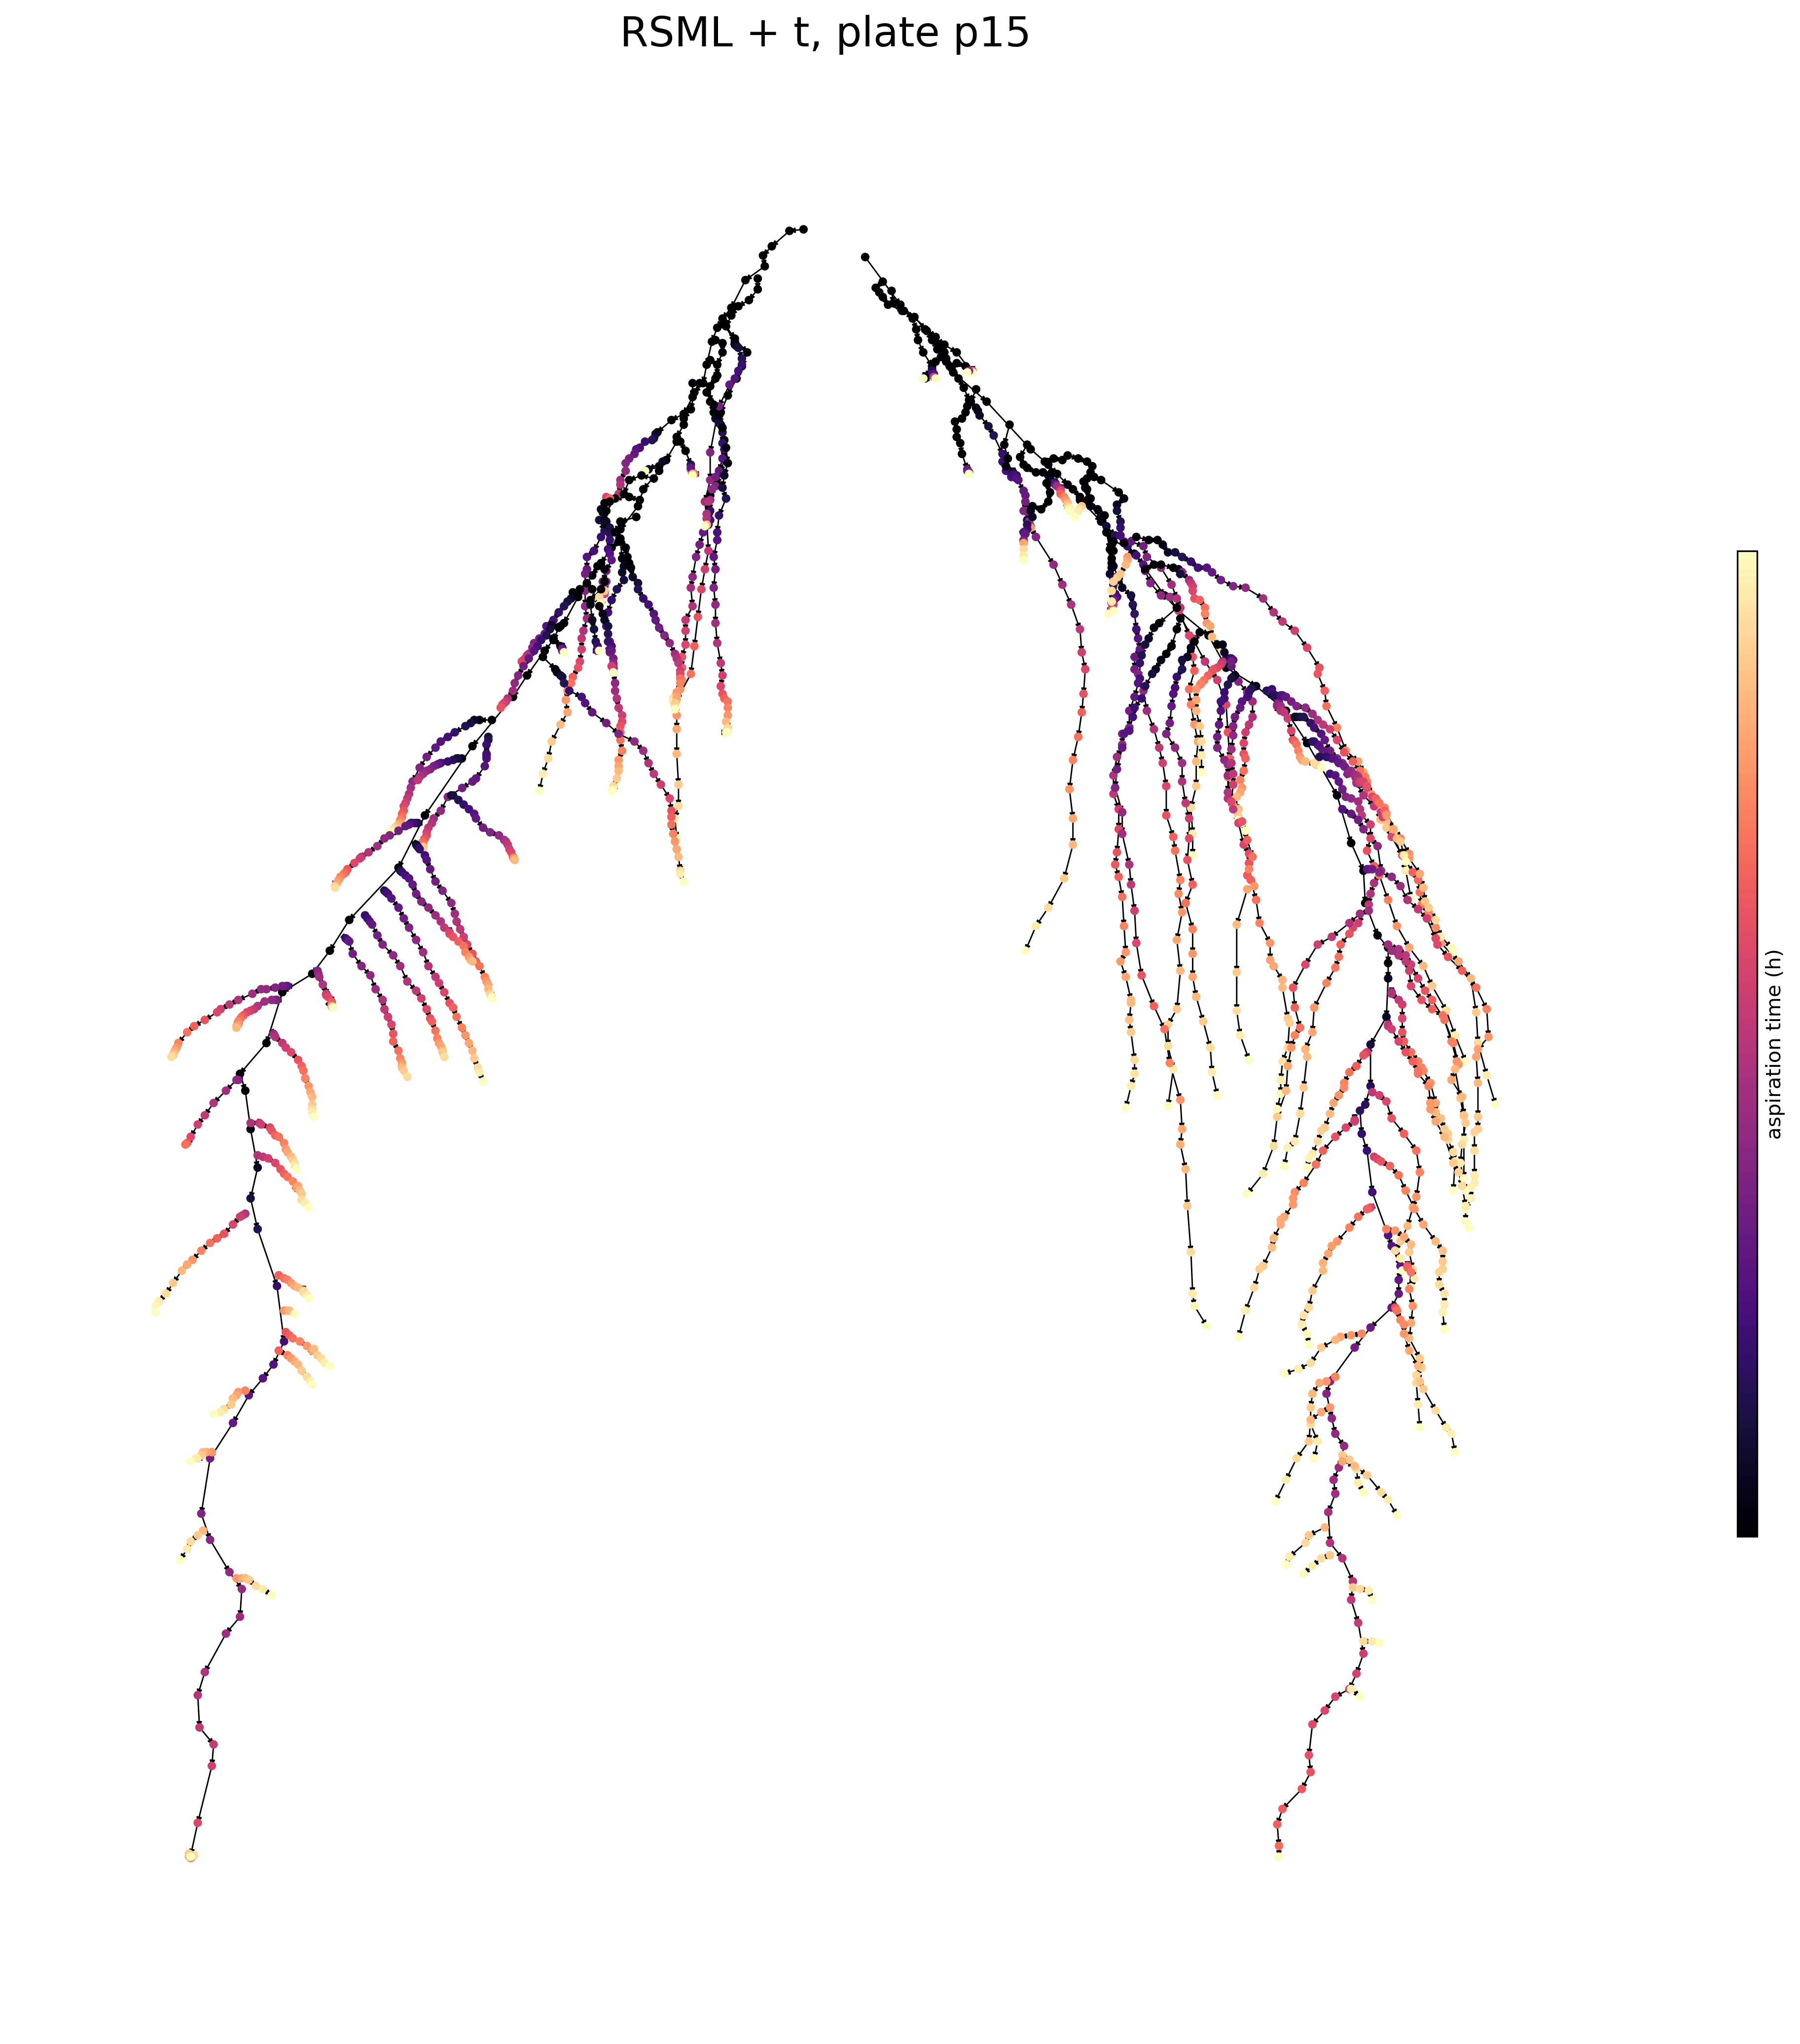

In [3]:
file = 'p15.rsml' # 06 has low high heterogenous nutrient, 04 has high high homogeneous nutrient, 15 has low high homogeneous nutrient.
left_root, right_root, r = splitrsml2root(file)
G_root, r = rsml2nx(file)
plot_rsmlt(G_root, plate= 'p15',  save_name= None)

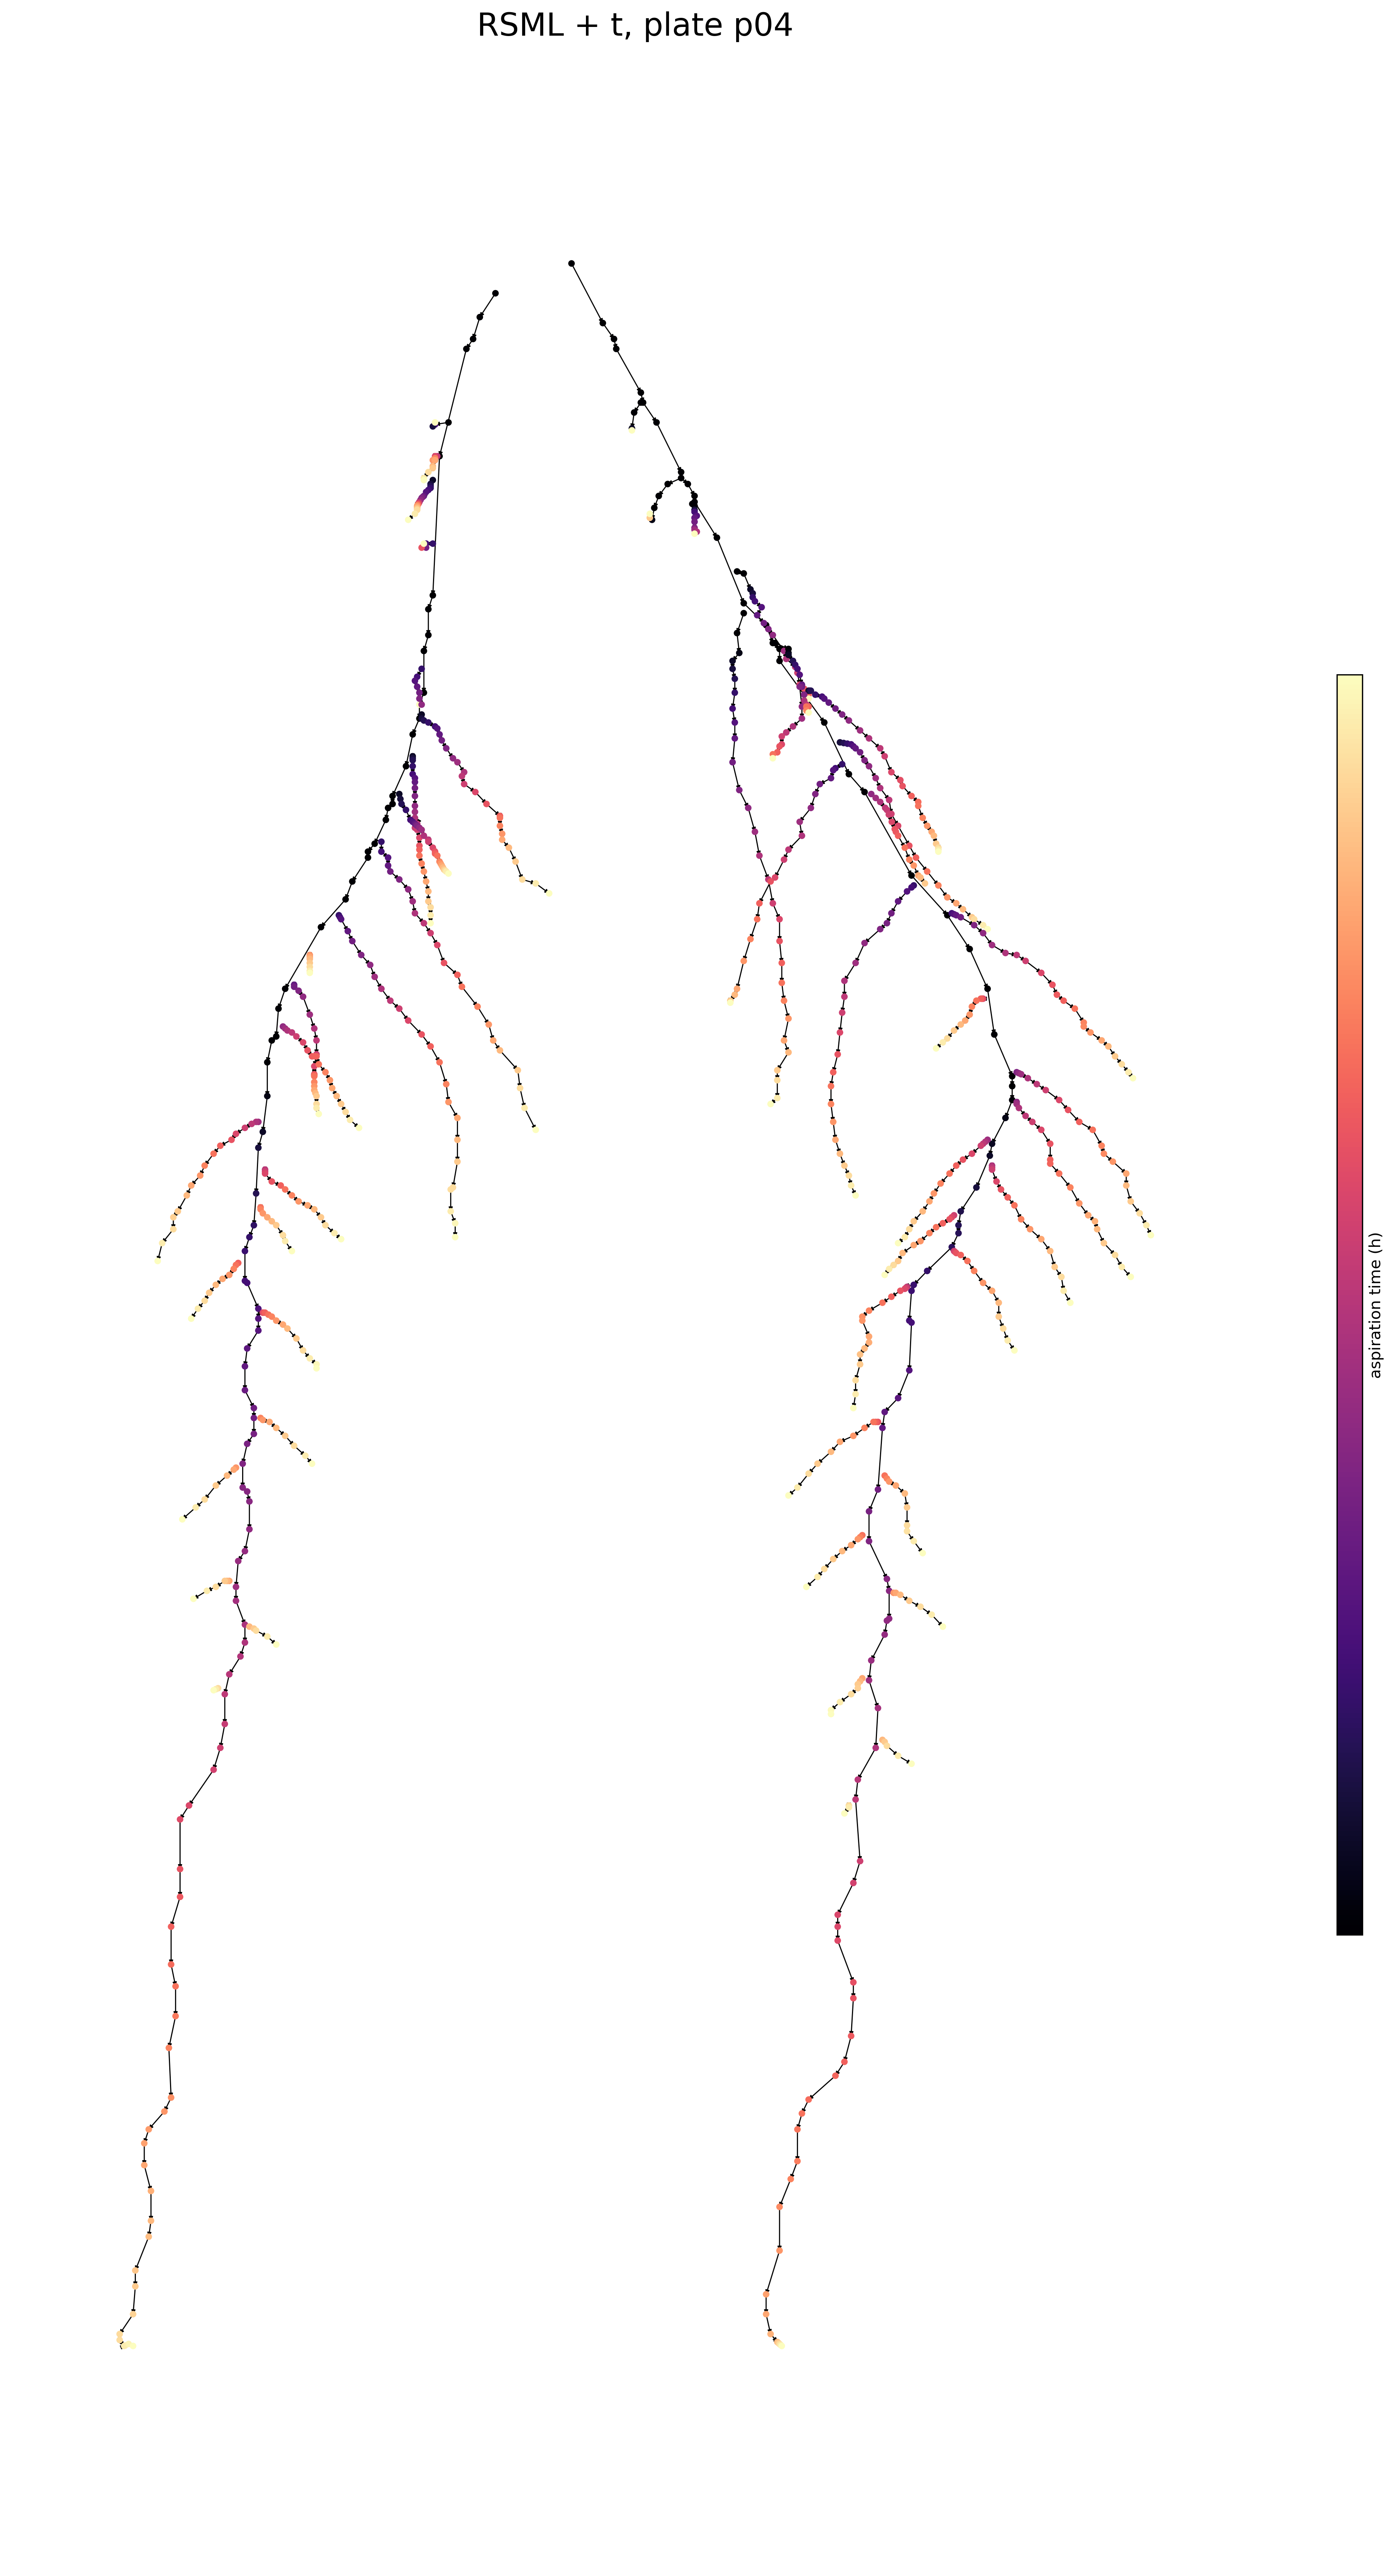

In [4]:
file = 'p04.rsml' # 06 has low high heterogenous nutrient, 04 has high  , 15 has low low homogeneous nutrient.
left_root, right_root, r = splitrsml2root(file)
G_root, r = rsml2nx(file)
plot_rsmlt(G_root, plate= 'p04',  save_name= None)

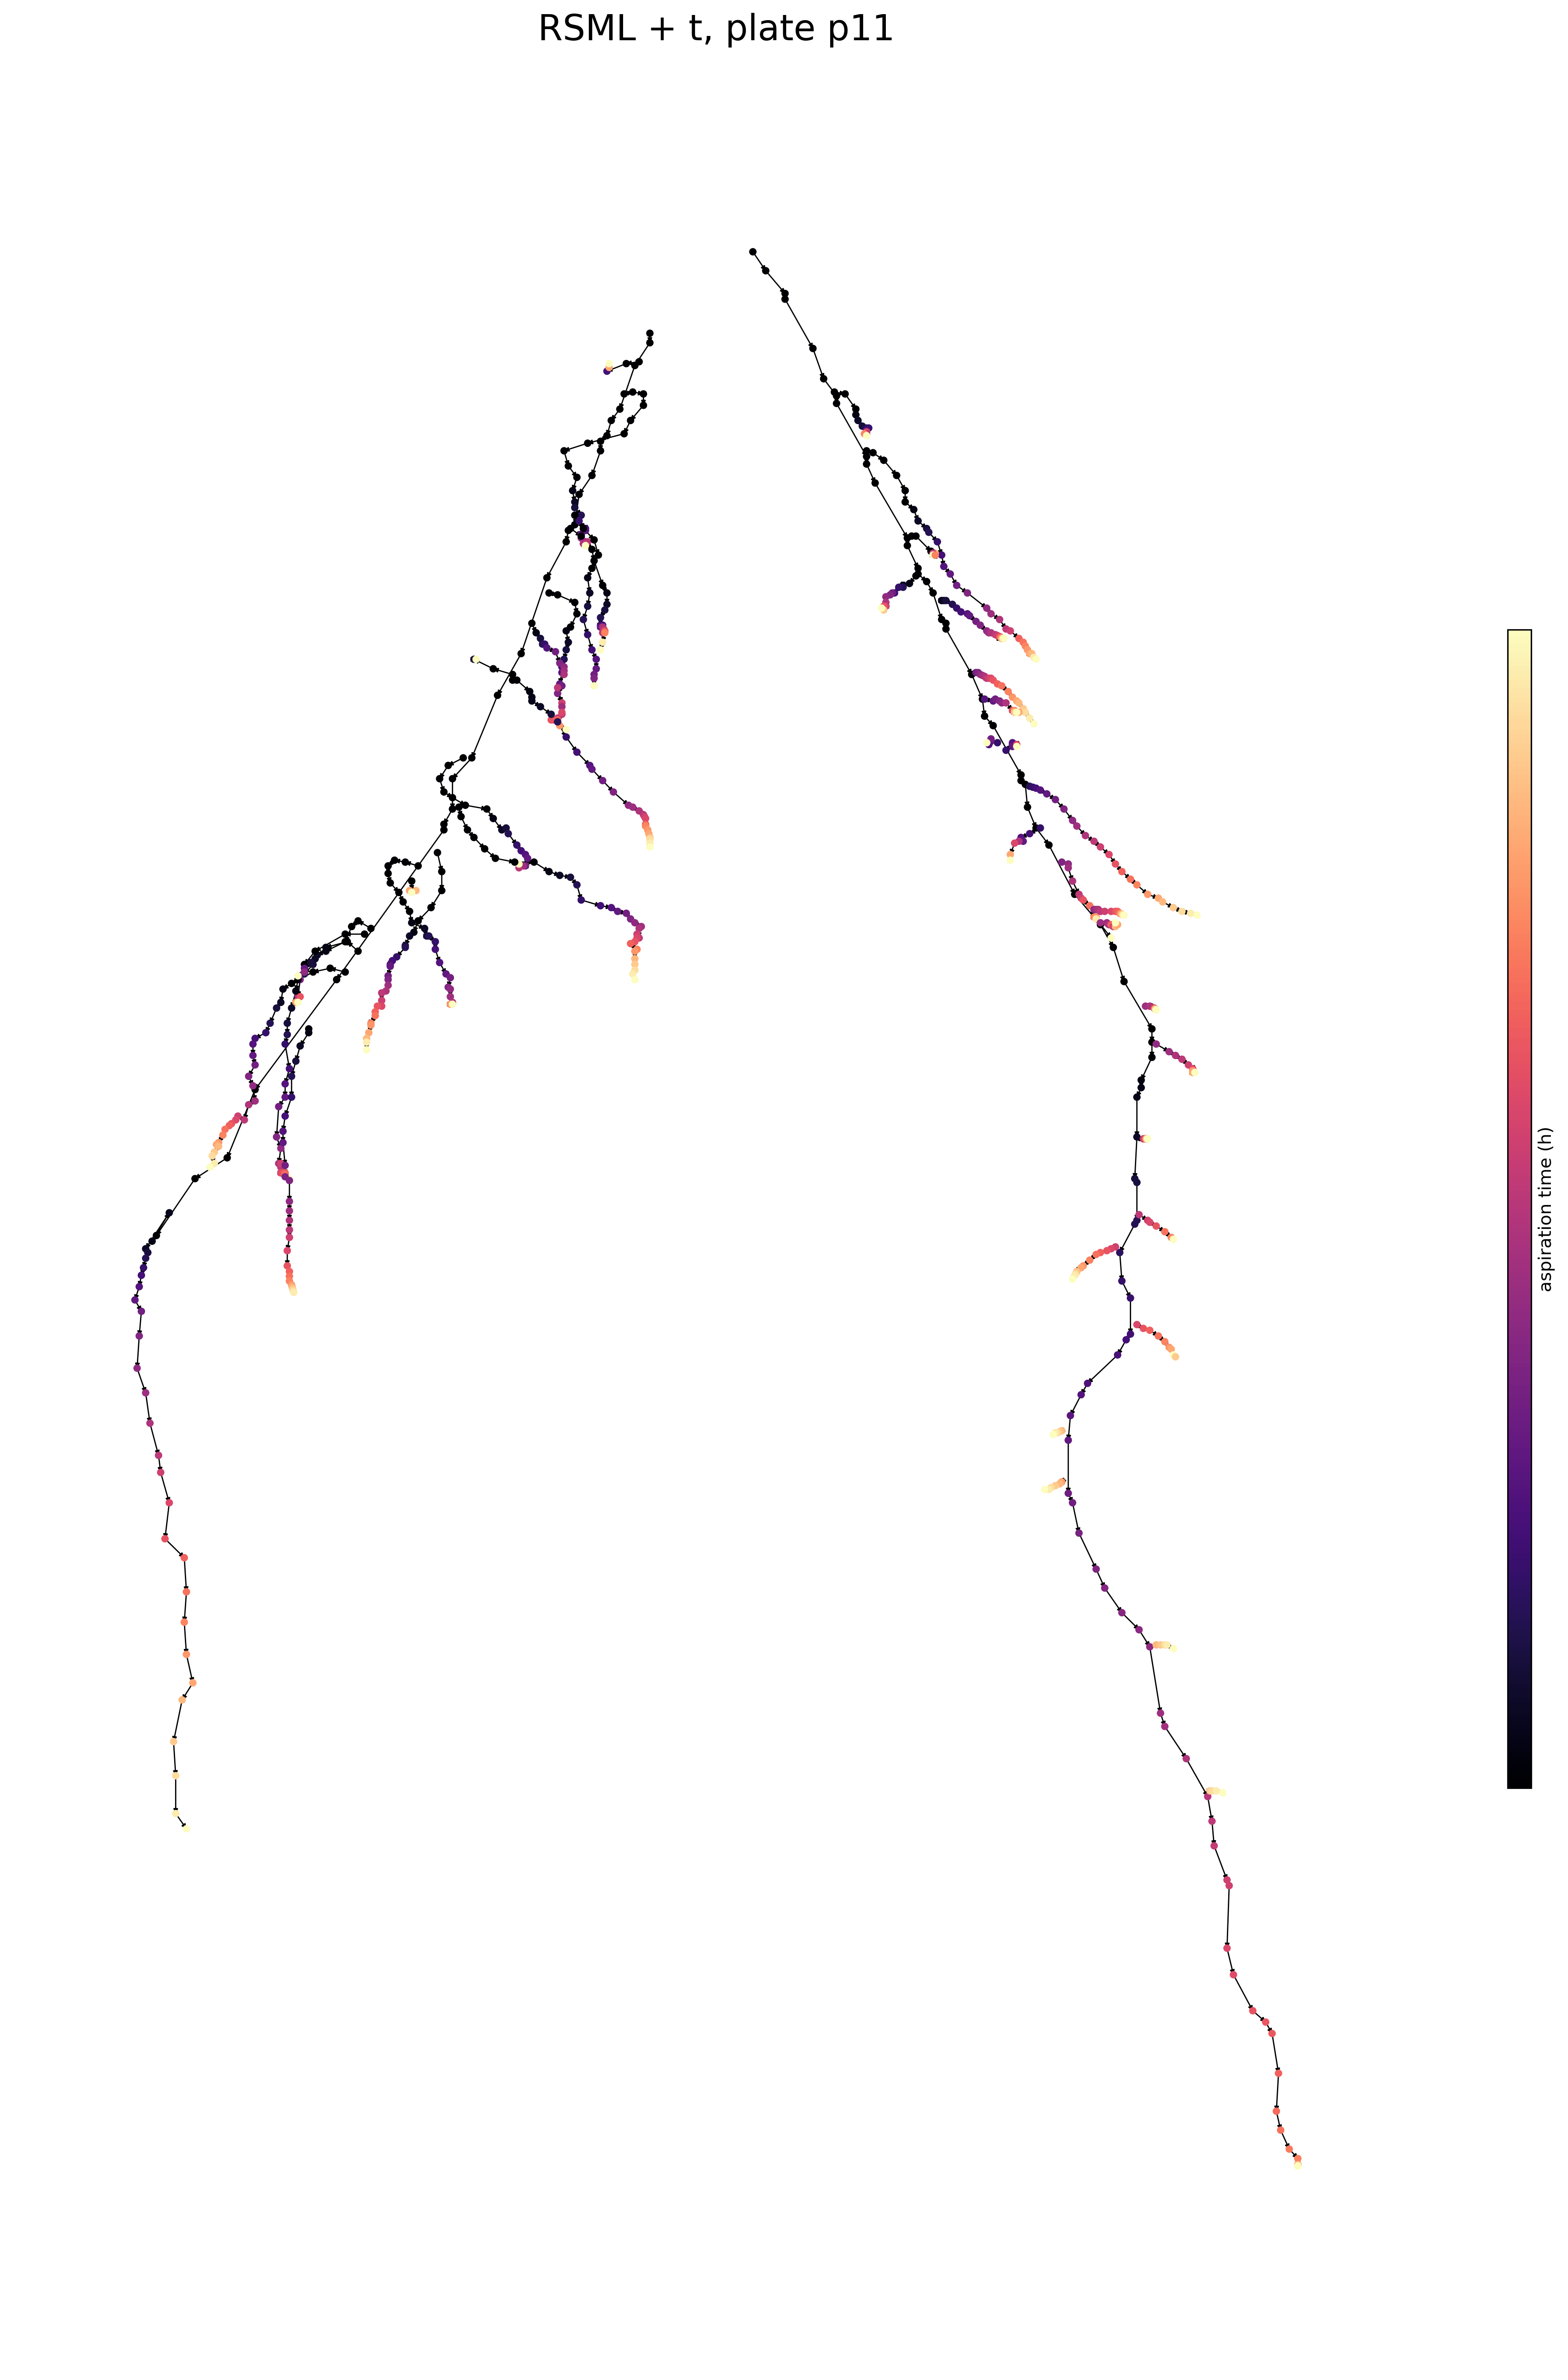

In [5]:
file = 'p11.rsml' # 06 has low high heterogenous nutrient, 04 has high  , 15 has low low homogeneous nutrient.
left_root, right_root, r = splitrsml2root(file)
G_root, r = rsml2nx(file)
plot_rsmlt(G_root, plate= 'p11',  save_name= None)

In [6]:
class Node:
    def __init__(self, pos, t):
        self.pos = np.array([pos[0], pos[1]])
        self.t = t
        self.children = []


def branch_builder(branch: list):
    # temp = [node['@coord_t'] for node in branch]
    # print(temp)
    cur_max_time = float(branch[-1]['@coord_t'])
    branch.reverse()
    prev = branch[0]
    prev = Node((float(prev['@coord_x']), -float(prev['@coord_y'])), float(prev['@coord_t']))
    for node in branch[1:]:
        cur = Node((float(node['@coord_x']), -float(node['@coord_y'])), float(node['@coord_t']))
        cur.children.append(prev)
        prev = cur
    return prev, cur_max_time

def root_builder(root_dat):
    max_time = 0
    main_root, cur_max_time = branch_builder(root_dat['root']['geometry']['polyline']['point'])
    max_time = max(max_time, cur_max_time)
    laterals = []
    for branch_dat in root_dat['root']['root']:
        branch, cur_max_time = branch_builder(branch_dat['geometry']['polyline']['point'])
        laterals.append(branch)
        max_time = max(max_time, cur_max_time)

    main_nodes = []
    node = main_root
    while True:
        main_nodes.append(node)
        if len(node.children) < 1: break
        node = node.children[0]
    
    res_list_1 = []
    parent_nodes = []
    for lateral in laterals:
        main_node = main_nodes[0]
        min_dist = float('inf')
        parent_node = None
        while True:
            if not main_node.children: break
            if main_node.t > lateral.t: 
                break
            if np.linalg.norm(main_node.pos-lateral.pos) < min_dist:
                min_dist = np.linalg.norm(main_node.pos-lateral.pos)
                parent_node = main_node
            main_node = main_node.children[0]
        parent_nodes.append(parent_node)
        res_list_1.append(min_dist)

    # some sanity check:
    # res_list_2 = []
    # time_list = []
    # for lateral in laterals:
    #     main_node = main_nodes[0]
    #     min_dist = float('inf')
    #     while True:
    #         if not main_node.children: break
    #         if np.linalg.norm(main_node.pos-lateral.pos) < min_dist:
    #             time_list.append(main_node.t)
    #             min_dist = np.linalg.norm(main_node.pos-lateral.pos)
    #         main_node = main_node.children[0]
    #     res_list_2.append(min_dist)
    # for a, b, c in zip(res_list_1, res_list_2, time_list):
    #     if a!= b: 
    #         print(a,b,c)

    for parent_node, lateral in zip(parent_nodes, laterals):
        parent_node.children.append(lateral)
    
    return main_root, max_time
    

In [7]:
def length_by_time(root, max_time):

    def dfs(node: Node, parent: Node, edges: list, time_limit: int):
        if parent:
            # print(np.linalg.norm(node.pos-parent.pos))
            edges.append(np.linalg.norm(node.pos-parent.pos))
        for child in node.children:
            if child.t <= time_limit:
                dfs(child, node, edges, time_limit)
    length_list = []
    for i in range(int(max_time)+1):
        cur_edges = []
        dfs(root, None, cur_edges, i)
        length_list.append(np.sum(cur_edges))
    
    return length_list, [i for i in range(int(max_time)+1)]
    


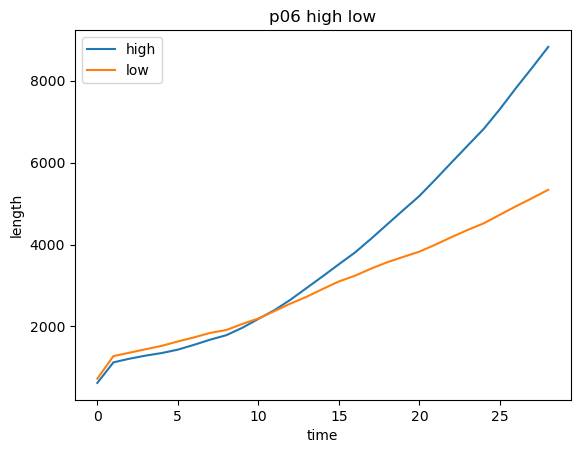

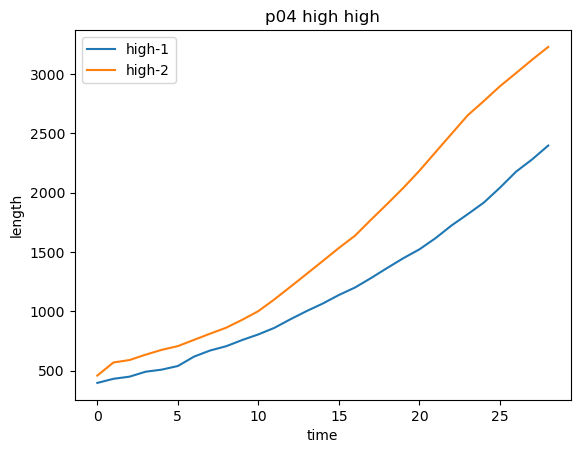

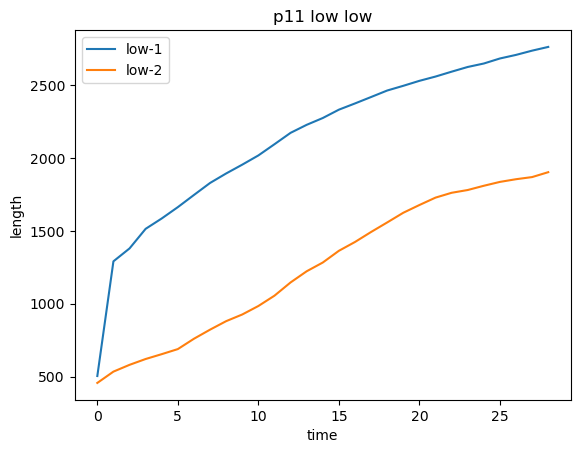

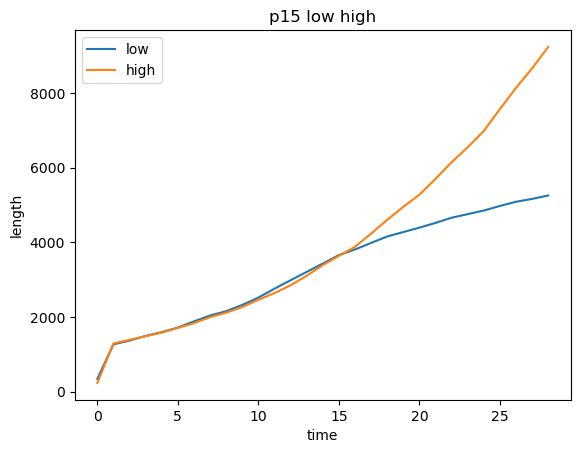

In [8]:
file = 'p06.rsml' 
G_root, r = rsml2nx(file)
plot_series = []
for plant in r['rsml']['scene']['plant']:
    root, max_time = root_builder(plant)
    plot_series.append(length_by_time(root, max_time))
plt.plot(plot_series[0][1], plot_series[0][0], label ='high')
plt.plot(plot_series[1][1], plot_series[1][0], label ='low')

plt.xlabel("time")
plt.ylabel("length")
plt.legend()
plt.title('p06 high low')
plt.show()

file = 'p04.rsml' 
G_root, r = rsml2nx(file)
plot_series = []
for plant in r['rsml']['scene']['plant']:
    root, max_time = root_builder(plant)
    plot_series.append(length_by_time(root, max_time))
plt.plot(plot_series[0][1], plot_series[0][0], label ='high-1')
plt.plot(plot_series[1][1], plot_series[1][0], label ='high-2')

plt.xlabel("time")
plt.ylabel("length")
plt.legend()
plt.title('p04 high high')
plt.show()

file = 'p11.rsml' 
G_root, r = rsml2nx(file)
plot_series = []
for plant in r['rsml']['scene']['plant']:
    root, max_time = root_builder(plant)
    plot_series.append(length_by_time(root, max_time))
plt.plot(plot_series[0][1], plot_series[0][0], label ='low-1')
plt.plot(plot_series[1][1], plot_series[1][0], label ='low-2')

plt.xlabel("time")
plt.ylabel("length")
plt.legend()
plt.title('p11 low low')
plt.show()

file = 'p15.rsml' 
G_root, r = rsml2nx(file)
plot_series = []
for plant in r['rsml']['scene']['plant']:
    root, max_time = root_builder(plant)
    plot_series.append(length_by_time(root, max_time))
plt.plot(plot_series[0][1], plot_series[0][0], label ='low')
plt.plot(plot_series[1][1], plot_series[1][0], label ='high')

plt.xlabel("time")
plt.ylabel("length")
plt.legend()
plt.title('p15 low high')
plt.show()

Creating distance image using KDTree for 37 nodes...
Time 0: 37 nodes, 15002 pixels covered
Coverage area: 3750.50, Average distance: 312.51
Creating distance image using KDTree for 107 nodes...
Time 1: 107 nodes, 21724 pixels covered
Coverage area: 5431.00, Average distance: 274.03
Creating distance image using KDTree for 125 nodes...
Time 2: 125 nodes, 23302 pixels covered
Coverage area: 5825.50, Average distance: 281.25
Creating distance image using KDTree for 146 nodes...
Time 3: 146 nodes, 24898 pixels covered
Coverage area: 6224.50, Average distance: 290.61
Creating distance image using KDTree for 168 nodes...
Time 4: 168 nodes, 26178 pixels covered
Coverage area: 6544.50, Average distance: 298.02
Creating distance image using KDTree for 193 nodes...
Time 5: 193 nodes, 27918 pixels covered
Coverage area: 6979.50, Average distance: 310.34
Creating distance image using KDTree for 220 nodes...
Time 6: 220 nodes, 30301 pixels covered
Coverage area: 7575.25, Average distance: 319.77
C

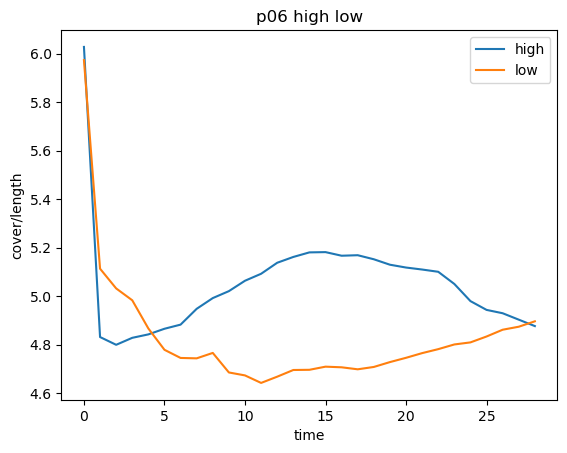

In [19]:
file = 'p06.rsml' 
G_root, r = rsml2nx(file)
plot_series = []
names = ['p06high', 'p06low']
for plant, name in zip(r['rsml']['scene']['plant'], names):
    root, max_time = root_builder(plant)
    length_list, time_list = length_by_time(root, max_time)
    calc = TimeAwareTreeCoverage(root, 3)
    area_list = []
    transport_list = []
    for t in range(int(max_time)+1):
        area, avg_distance,_,_ = calc.calculate_coverage_with_distance(t, precision=0.5, show_images=False)
        area_list.append(area)
        transport_list.append(avg_distance)
    ratio_list = [y/x for x, y in zip(length_list, area_list)]
    plot_series.append((ratio_list, time_list))
    # save dataframe
    df = pd.DataFrame(index=range(int(max_time)+1))
    df['time'] = time_list
    df['length'] = length_list
    df['cover'] = area_list
    df['avg_distance'] = transport_list
    df.to_csv("./output/"+name+".csv", index=False)
plt.plot(plot_series[0][1], plot_series[0][0], label ='high')
plt.plot(plot_series[1][1], plot_series[1][0], label ='low')
plt.xlabel("time")
plt.ylabel("cover/length")
plt.legend()
plt.title('p06 high low')
plt.show()


    

Creating distance image using KDTree for 34 nodes...
Time 0: 34 nodes, 8314 pixels covered
Coverage area: 2078.50, Average distance: 170.54
Creating distance image using KDTree for 125 nodes...
Time 1: 125 nodes, 25575 pixels covered
Coverage area: 6393.75, Average distance: 276.02
Creating distance image using KDTree for 144 nodes...
Time 2: 144 nodes, 27424 pixels covered
Coverage area: 6856.00, Average distance: 285.21
Creating distance image using KDTree for 167 nodes...
Time 3: 167 nodes, 29559 pixels covered
Coverage area: 7389.75, Average distance: 297.79
Creating distance image using KDTree for 192 nodes...
Time 4: 192 nodes, 31351 pixels covered
Coverage area: 7837.75, Average distance: 305.10
Creating distance image using KDTree for 218 nodes...
Time 5: 218 nodes, 33593 pixels covered
Coverage area: 8398.25, Average distance: 312.61
Creating distance image using KDTree for 246 nodes...
Time 6: 246 nodes, 37100 pixels covered
Coverage area: 9275.00, Average distance: 326.32
Cr

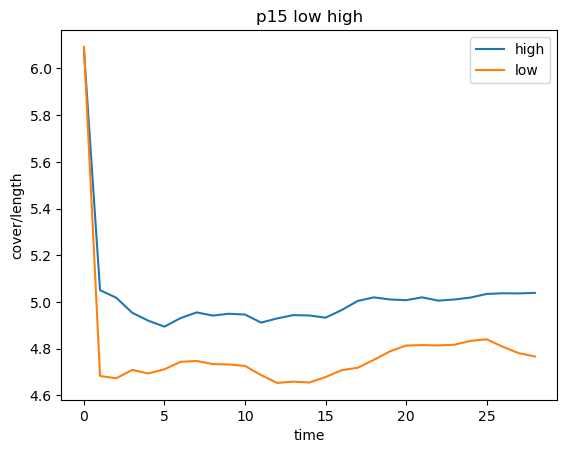

In [20]:
file = 'p15.rsml' 
G_root, r = rsml2nx(file)
plot_series = []
names = ['p15low', 'p15high']
for plant, name in zip(r['rsml']['scene']['plant'], names):
    root, max_time = root_builder(plant)
    length_list, time_list = length_by_time(root, max_time)
    calc = TimeAwareTreeCoverage(root, 3)
    area_list = []
    transport_list = []
    for t in range(int(max_time)+1):
        area, avg_distance,_,_ = calc.calculate_coverage_with_distance(t, precision=0.5, show_images=False)
        area_list.append(area)
        transport_list.append(avg_distance)
    ratio_list = [y/x for x, y in zip(length_list, area_list)]
    plot_series.append((ratio_list, time_list))
    # save dataframe
    df = pd.DataFrame(index=range(int(max_time)+1))
    df['time'] = time_list
    df['length'] = length_list
    df['cover'] = area_list
    df['avg_distance'] = transport_list
    df.to_csv("./output/"+name+".csv", index=False)
plt.plot(plot_series[0][1], plot_series[0][0], label ='high')
plt.plot(plot_series[1][1], plot_series[1][0], label ='low')
plt.xlabel("time")
plt.ylabel("cover/length")
plt.legend()
plt.title('p15 low high')
plt.show()

    

Creating distance image using KDTree for 28 nodes...
Time 0: 28 nodes, 9775 pixels covered
Coverage area: 2443.75, Average distance: 198.43
Creating distance image using KDTree for 32 nodes...
Time 1: 32 nodes, 10207 pixels covered
Coverage area: 2551.75, Average distance: 204.94
Creating distance image using KDTree for 35 nodes...
Time 2: 35 nodes, 10635 pixels covered
Coverage area: 2658.75, Average distance: 213.18
Creating distance image using KDTree for 42 nodes...
Time 3: 42 nodes, 11257 pixels covered
Coverage area: 2814.25, Average distance: 221.72
Creating distance image using KDTree for 49 nodes...
Time 4: 49 nodes, 11593 pixels covered
Coverage area: 2898.25, Average distance: 225.18
Creating distance image using KDTree for 56 nodes...
Time 5: 56 nodes, 12255 pixels covered
Coverage area: 3063.75, Average distance: 236.24
Creating distance image using KDTree for 68 nodes...
Time 6: 68 nodes, 13280 pixels covered
Coverage area: 3320.00, Average distance: 249.54
Creating dista

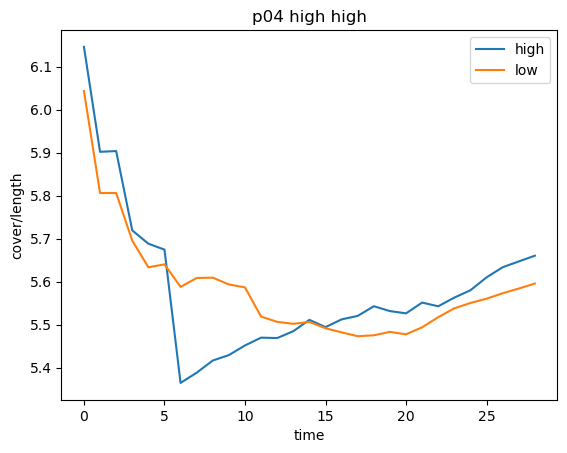

In [21]:
file = 'p04.rsml' 
G_root, r = rsml2nx(file)
plot_series = []
names = ['p04high_left', 'p04high_right']
for plant, name in zip(r['rsml']['scene']['plant'], names):
    root, max_time = root_builder(plant)
    length_list, time_list = length_by_time(root, max_time)
    calc = TimeAwareTreeCoverage(root, 3)
    area_list = []
    transport_list = []
    for t in range(int(max_time)+1):
        area, avg_distance,_,_ = calc.calculate_coverage_with_distance(t, precision=0.5, show_images=False)
        area_list.append(area)
        transport_list.append(avg_distance)
    ratio_list = [y/x for x, y in zip(length_list, area_list)]
    plot_series.append((ratio_list, time_list))
    # save dataframe
    df = pd.DataFrame(index=range(int(max_time)+1))
    df['time'] = time_list
    df['length'] = length_list
    df['cover'] = area_list
    df['avg_distance'] = transport_list
    df.to_csv("./output/"+name+".csv", index=False)
plt.plot(plot_series[0][1], plot_series[0][0], label ='high')
plt.plot(plot_series[1][1], plot_series[1][0], label ='low')
plt.xlabel("time")
plt.ylabel("cover/length")
plt.legend()
plt.title('p04 high high')
plt.show()

    

Creating distance image using KDTree for 25 nodes...
Time 0: 25 nodes, 12232 pixels covered
Coverage area: 3058.00, Average distance: 251.02
Creating distance image using KDTree for 108 nodes...
Time 1: 108 nodes, 24134 pixels covered
Coverage area: 6033.50, Average distance: 264.38
Creating distance image using KDTree for 129 nodes...
Time 2: 129 nodes, 25857 pixels covered
Coverage area: 6464.25, Average distance: 266.96
Creating distance image using KDTree for 150 nodes...
Time 3: 150 nodes, 27897 pixels covered
Coverage area: 6974.25, Average distance: 272.14
Creating distance image using KDTree for 169 nodes...
Time 4: 169 nodes, 29388 pixels covered
Coverage area: 7347.00, Average distance: 275.51
Creating distance image using KDTree for 188 nodes...
Time 5: 188 nodes, 30814 pixels covered
Coverage area: 7703.50, Average distance: 278.50
Creating distance image using KDTree for 207 nodes...
Time 6: 207 nodes, 32621 pixels covered
Coverage area: 8155.25, Average distance: 282.35
C

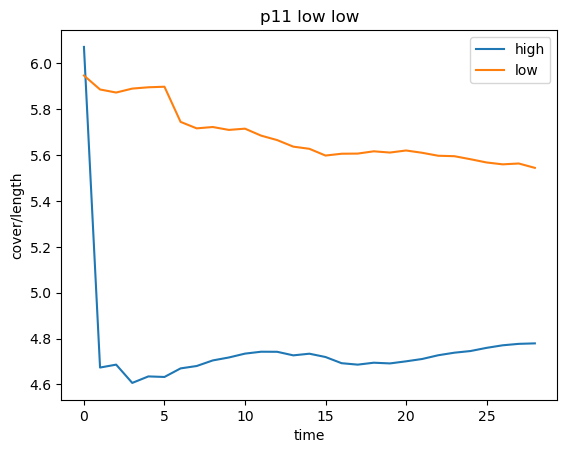

Creating distance image using KDTree for 25 nodes...
Time 0: 25 nodes, 304490 pixels covered
Coverage area: 3044.90, Average distance: 251.28
Creating distance image using KDTree for 108 nodes...
Time 1: 108 nodes, 597498 pixels covered
Coverage area: 5974.98, Average distance: 265.25
Creating distance image using KDTree for 129 nodes...
Time 2: 129 nodes, 639931 pixels covered
Coverage area: 6399.31, Average distance: 267.74
Creating distance image using KDTree for 150 nodes...
Time 3: 150 nodes, 690203 pixels covered
Coverage area: 6902.03, Average distance: 272.92
Creating distance image using KDTree for 169 nodes...
Time 4: 169 nodes, 726379 pixels covered
Coverage area: 7263.79, Average distance: 276.22
Creating distance image using KDTree for 188 nodes...
Time 5: 188 nodes, 760772 pixels covered
Coverage area: 7607.72, Average distance: 279.04
Creating distance image using KDTree for 207 nodes...
Time 6: 207 nodes, 805060 pixels covered
Coverage area: 8050.60, Average distance: 2

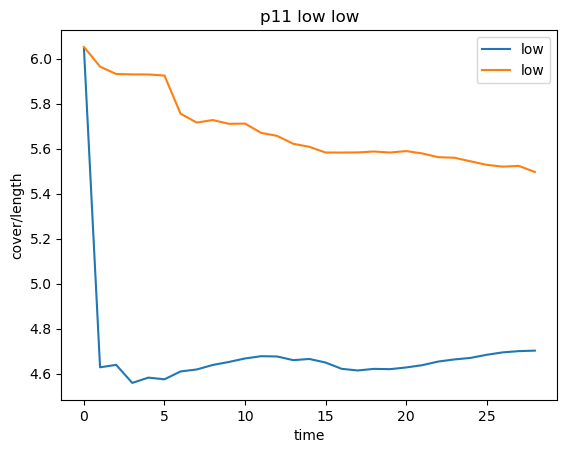

In [22]:
file = 'p11.rsml' 
G_root, r = rsml2nx(file)
plot_series = []
names = ['p11low_left', 'p11low_right']
for plant, name in zip(r['rsml']['scene']['plant'], names):
    root, max_time = root_builder(plant)
    length_list, time_list = length_by_time(root, max_time)
    calc = TimeAwareTreeCoverage(root, 3)
    area_list = []
    transport_list = []
    for t in range(int(max_time)+1):
        area, avg_distance,_,_ = calc.calculate_coverage_with_distance(t, precision=0.5, show_images=False)
        area_list.append(area)
        transport_list.append(avg_distance)
    ratio_list = [y/x for x, y in zip(length_list, area_list)]
    plot_series.append((ratio_list, time_list))
    # save dataframe
    df = pd.DataFrame(index=range(int(max_time)+1))
    df['time'] = time_list
    df['length'] = length_list
    df['cover'] = area_list
    df['avg_distance'] = transport_list
    df.to_csv("./output/"+name+".csv", index=False)
plt.plot(plot_series[0][1], plot_series[0][0], label ='high')
plt.plot(plot_series[1][1], plot_series[1][0], label ='low')
plt.xlabel("time")
plt.ylabel("cover/length")
plt.legend()
plt.title('p11 low low')
plt.show()

  